In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


# ============================================================
# CONFIG
# ============================================================
DATA_PATH   = "data2.csv"
# Số ngày nhìn lại
LOOKBACK    = 30      # giống LSTM
FORECAST    = 7       # chỉ dự đoán ngày T+7
TRAIN_RATIO = 0.4
EPS = 1e-8
RANDOM_STATE = 42

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])
print(df)
df = df.sort_values('Date').reset_index(drop=True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
print(df)
print(f"Data: {len(df)} rows | {df['Date'].min().date()} → {df['Date'].max().date()}")

# ============================================================
# FEATURE ENGINEERING (NHẸ – ĐỦ DÙNG)
# ============================================================
df['Return_1d'] = df['Close'].pct_change()
df['HL_Range'] = df['High'] - df['Low']
df['OC_Range'] = abs(df['Open'] - df['Close'])

for p in [5, 10, 20]:
    df[f'SMA_{p}'] = df['Close'].rolling(p).mean()
    df[f'Price_SMA_{p}'] = df['Close'] / (df[f'SMA_{p}'] + EPS) - 1

# RSI
delta = df['Close'].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / (loss + EPS)
df['RSI_14'] = 100 - (100 / (1 + rs))

# Volatility
df['Volatility_20'] = df['Return_1d'].rolling(20).std()

df = df.dropna().reset_index(drop=True)
print(f"After feature engineering: {df.shape}")

# ============================================================
# SCALE DATA (GIỐNG LSTM)
# ============================================================
feature_cols = [c for c in df.columns if c not in ['Date']]
target_col = 'Close'
target_idx = feature_cols.index(target_col)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols].values)

target_scaler = MinMaxScaler()
target_scaler.fit(df[['Close']].values)

# ============================================================
# BUILD SEQUENCES (GIỐNG LSTM)
# X: (samples, LOOKBACK, features)
# y: Close tại T+7
# ============================================================
X, y = [], []

for i in range(LOOKBACK, len(scaled) - FORECAST + 1):
    X.append(scaled[i - LOOKBACK:i])
    y.append(scaled[i + FORECAST - 1, target_idx])

X = np.array(X)
y = np.array(y)

print(f"Sequences: X {X.shape} | y {y.shape}")

# ============================================================
# FLATTEN = HIDDEN STATE GIẢ (THAY LSTM)
# ============================================================
X_flat = X.reshape(X.shape[0], -1)

# ============================================================
# TRAIN / TEST SPLIT (TIME-AWARE)
# ============================================================
split_idx = int(len(X_flat) * TRAIN_RATIO)

X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# ============================================================
# MODELS = "LSTM CELL" THAY THẾ
# ============================================================
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ),
    "Ridge": Ridge(alpha=1.0)
}

preds = {}

print("\nTraining models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds[name] = model.predict(X_test)
    print(f"✓ {name} trained")

# ============================================================
# ENSEMBLE = DENSE LAYER GIẢ
# ============================================================
y_pred_ensemble = (
    0.5 * preds["RandomForest"] +
    0.3 * preds["GradientBoosting"] +
    0.2 * preds["Ridge"]
)

# ============================================================
# INVERSE SCALE
# ============================================================
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_inv = target_scaler.inverse_transform(y_pred_ensemble.reshape(-1, 1)).ravel()


# ============================================================
# R2 SCORE FOR EACH MODEL
# ============================================================

print("\n📈 R2 Score (T+7 Forecast)")

for name, y_pred_scaled in preds.items():
    # Inverse scale prediction của từng model
    y_pred_inv_model = target_scaler.inverse_transform(
        y_pred_scaled.reshape(-1, 1)
    ).ravel()

    r2 = r2_score(y_test_inv, y_pred_inv_model)
    print(f"{name:18s}: R2 = {r2:.4f}")


# ============================================================
# EVALUATION
# ============================================================
mae = mean_absolute_error(y_test_inv, y_pred_inv)
# rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)

print("\n📊 Evaluation (T+7 Forecast)")
print(f"MAE : {mae:.4f}")
# print(f"RMSE: {rmse:.4f}")

# ============================================================
# PLOT
# ============================================================
plt.figure(figsize=(16, 5))
plt.plot(y_test_inv, label="Actual Close (T+7)", lw=2)
plt.plot(y_pred_inv, "--", label="ML-LSTM Forecast", lw=2)
plt.title("ML-based LSTM-style Forecast (T+7)")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


           Date   Price    Open    High     Low          Vol
0    2024-05-26  0.5341  0.5416  0.5418  0.5328  178450000.0
1    2024-05-25  0.5416  0.5359  0.5425  0.5334  246380000.0
2    2024-05-24  0.5358  0.5288  0.5372  0.5169  513880000.0
3    2024-05-23  0.5288  0.5269  0.5456  0.5091  948100000.0
4    2024-05-22  0.5268  0.5372  0.5382  0.5236  509460000.0
...         ...     ...     ...     ...     ...          ...
2187 2018-05-30  0.5938  0.5994  0.6255  0.5786  132830000.0
2188 2018-05-29  0.5994  0.5476  0.6088  0.5444  155950000.0
2189 2018-05-28  0.5476  0.6047  0.6075  0.5460  158340000.0
2190 2018-05-27  0.6046  0.6088  0.6119  0.5988   95150000.0
2191 2018-05-26  0.6088  0.6056  0.6247  0.5989   99110000.0

[2192 rows x 6 columns]
           Date    Open    High     Low   Close       Volume
0    2018-05-26  0.6088  0.6056  0.6247  0.5989   99110000.0
1    2018-05-27  0.6046  0.6088  0.6119  0.5988   95150000.0
2    2018-05-28  0.5476  0.6047  0.6075  0.5460  158340000.0

KeyboardInterrupt: 

           Date   Price    Open    High     Low          Vol
0    2024-05-26  0.5341  0.5416  0.5418  0.5328  178450000.0
1    2024-05-25  0.5416  0.5359  0.5425  0.5334  246380000.0
2    2024-05-24  0.5358  0.5288  0.5372  0.5169  513880000.0
3    2024-05-23  0.5288  0.5269  0.5456  0.5091  948100000.0
4    2024-05-22  0.5268  0.5372  0.5382  0.5236  509460000.0
...         ...     ...     ...     ...     ...          ...
2187 2018-05-30  0.5938  0.5994  0.6255  0.5786  132830000.0
2188 2018-05-29  0.5994  0.5476  0.6088  0.5444  155950000.0
2189 2018-05-28  0.5476  0.6047  0.6075  0.5460  158340000.0
2190 2018-05-27  0.6046  0.6088  0.6119  0.5988   95150000.0
2191 2018-05-26  0.6088  0.6056  0.6247  0.5989   99110000.0

[2192 rows x 6 columns]
           Date   Price    Open    High     Low          Vol
0    2018-05-26  0.6088  0.6056  0.6247  0.5989   99110000.0
1    2018-05-27  0.6046  0.6088  0.6119  0.5988   95150000.0
2    2018-05-28  0.5476  0.6047  0.6075  0.5460  158340000.0

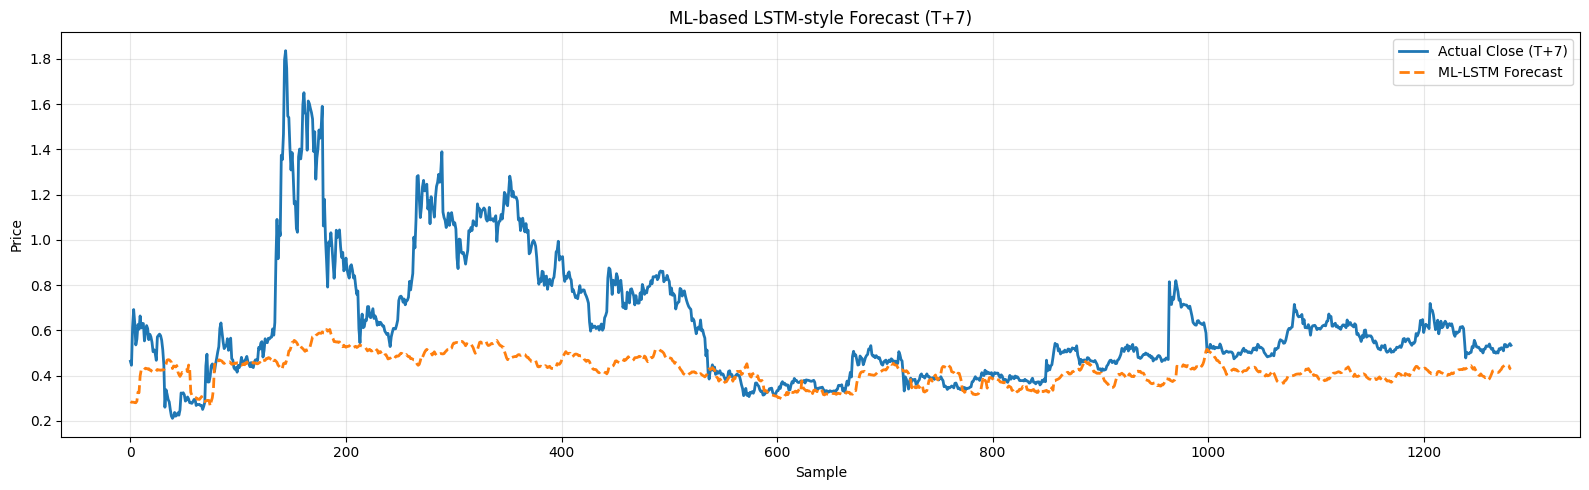

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


# ============================================================
# CONFIG
# ============================================================
DATA_PATH   = "data2.csv"
# Số ngày nhìn lại
LOOKBACK    = 30      # giống LSTM
FORECAST    = 7       # chỉ dự đoán ngày T+7
TRAIN_RATIO = 0.4
EPS = 1e-8
RANDOM_STATE = 42

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])
print(df)
df = df.sort_values('Date').reset_index(drop=True)
print(df)
print(f"Data: {len(df)} rows | {df['Date'].min().date()} → {df['Date'].max().date()}")

# ============================================================
# FEATURE ENGINEERING (NHẸ – ĐỦ DÙNG)
# ============================================================
df['Return_1d'] = df['Price'].pct_change()
df['HL_Range'] = df['High'] - df['Low']
df['OC_Range'] = abs(df['Open'] - df['Price'])

for p in [5, 10, 20]:
    df[f'SMA_{p}'] = df['Price'].rolling(p).mean()
    df[f'Price_SMA_{p}'] = df['Price'] / (df[f'SMA_{p}'] + EPS) - 1

# RSI
delta = df['Price'].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / (loss + EPS)
df['RSI_14'] = 100 - (100 / (1 + rs))

# Volatility
df['Volatility_20'] = df['Return_1d'].rolling(20).std()

df = df.dropna().reset_index(drop=True)
print(f"After feature engineering: {df.shape}")

# ============================================================
# SCALE DATA (GIỐNG LSTM)
# ============================================================
feature_cols = [c for c in df.columns if c not in ['Date']]
target_col = 'Price'
target_idx = feature_cols.index(target_col)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols].values)

target_scaler = MinMaxScaler()
target_scaler.fit(df[['Price']].values)

# ============================================================
# BUILD SEQUENCES (GIỐNG LSTM)
# X: (samples, LOOKBACK, features)
# y: Close tại T+7
# ============================================================
X, y = [], []

for i in range(LOOKBACK, len(scaled) - FORECAST + 1):
    X.append(scaled[i - LOOKBACK:i])
    y.append(scaled[i + FORECAST - 1, target_idx])

X = np.array(X)
y = np.array(y)

print(f"Sequences: X {X.shape} | y {y.shape}")

# ============================================================
# FLATTEN = HIDDEN STATE GIẢ (THAY LSTM)
# ============================================================
X_flat = X.reshape(X.shape[0], -1)

# ============================================================
# TRAIN / TEST SPLIT (TIME-AWARE)
# ============================================================
split_idx = int(len(X_flat) * TRAIN_RATIO)

X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# ============================================================
# MODELS = "LSTM CELL" THAY THẾ
# ============================================================
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        random_state=RANDOM_STATE
    ),
    "Ridge": Ridge(alpha=1.0)
}

preds = {}

print("\nTraining models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds[name] = model.predict(X_test)
    print(f"✓ {name} trained")

# ============================================================
# ENSEMBLE = DENSE LAYER GIẢ
# ============================================================
y_pred_ensemble = (
    0.5 * preds["RandomForest"] +
    0.3 * preds["GradientBoosting"] +
    0.2 * preds["Ridge"]
)

# ============================================================
# INVERSE SCALE
# ============================================================
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_inv = target_scaler.inverse_transform(y_pred_ensemble.reshape(-1, 1)).ravel()


# ============================================================
# R2 SCORE FOR EACH MODEL
# ============================================================

print("\n📈 R2 Score (T+7 Forecast)")

for name, y_pred_scaled in preds.items():
    # Inverse scale prediction của từng model
    y_pred_inv_model = target_scaler.inverse_transform(
        y_pred_scaled.reshape(-1, 1)
    ).ravel()

    r2 = r2_score(y_test_inv, y_pred_inv_model)
    print(f"{name:18s}: R2 = {r2:.4f}")


# ============================================================
# EVALUATION
# ============================================================
mae = mean_absolute_error(y_test_inv, y_pred_inv)
# rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)

print("\n📊 Evaluation (T+7 Forecast)")
print(f"MAE : {mae:.4f}")
# print(f"RMSE: {rmse:.4f}")

# ============================================================
# PLOT
# ============================================================
plt.figure(figsize=(16, 5))
plt.plot(y_test_inv, label="Actual Close (T+7)", lw=2)
plt.plot(y_pred_inv, "--", label="ML-LSTM Forecast", lw=2)
plt.title("ML-based LSTM-style Forecast (T+7)")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# ============================================================
# PREDICT T+7 FROM LATEST AVAILABLE DATE
# ============================================================

# Lấy LOOKBACK ngày cuối cùng
latest_window = scaled[-LOOKBACK:]                     # shape: (30, features)

# Reshape giống lúc train
latest_window = latest_window.reshape(1, LOOKBACK, -1)
latest_flat = latest_window.reshape(1, -1)              # shape: (1, 30*features)

# Dự đoán bằng từng model
pred_rf = models["RandomForest"].predict(latest_flat)
pred_gb = models["GradientBoosting"].predict(latest_flat)
pred_ridge = models["Ridge"].predict(latest_flat)

# Ensemble
pred_ensemble_scaled = (
    0.5 * pred_rf +
    0.3 * pred_gb +
    0.2 * pred_ridge
)

# Inverse scale về giá thật
pred_close_t7 = target_scaler.inverse_transform(
    pred_ensemble_scaled.reshape(-1, 1)
)[0, 0]

# Ngày hiện tại và ngày dự đoán
last_date = df['Date'].iloc[-1]
forecast_date = last_date + pd.Timedelta(days=FORECAST)

print("\n📈 FORECAST FROM LATEST DATA")
print(f"Last available date : {last_date.date()}")
print(f"Forecast date (T+7) : {forecast_date.date()}")
print(f"Predicted Close    : {pred_close_t7}")



📈 FORECAST FROM LATEST DATA
Last available date : 2024-05-26
Forecast date (T+7) : 2024-06-02
Predicted Close    : 0.413622557968405
